In [1]:
from contra_qa.text_generation.boolean3_NP_and import boolean3
from contra_qa.text_generation.boolean4_VP_and import boolean4
from contra_qa.text_generation.boolean5_AP_and import boolean5
from contra_qa.text_processing.functions import simple_pre_process_text_df
from contra_qa.plots.functions  import plot_histogram_from_labels, plot_confusion_matrix

from contra_qa.train_functions.RNNConfig import RNNConfig
import numpy as np
import torch
import torch.nn as nn
from torchtext import data

import pandas as pd
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

% matplotlib inline

# manipulating datasets: b3

In [2]:
boolean3()

In [3]:
df3 = pd.read_csv("data/boolean3_train.csv")
df3test = pd.read_csv("data/boolean3_test.csv")

In [4]:
df3.tail()

,sentence1,sentence2,and_A,and_B,label
9995,Dawn went to Mangalia and Dej,Ramon didn't go to Dej,Dawn went to Mangalia,Dawn went to Dej,0
9996,Dorothy has traveled to Mangalia and Giurgiu,Loretta didn't travel to Mangalia,Dorothy has traveled to Mangalia,Dorothy has traveled to Giurgiu,0
9997,Beverly has visited Giurgiu and Dej,Beverly didn't visit Reghin,Beverly has visited Giurgiu,Beverly has visited Dej,0
9998,Flora has visited Baia Mare and Hunedoara,Flora didn't visit Bucharest,Flora has visited Baia Mare,Flora has visited Hunedoara,0
9999,Cora and Ruby have traveled to Blaj,Toni didn't travel to Blaj,Cora has traveled to Blaj,Ruby has traveled to Blaj,0


In [5]:
df3test.tail()

,sentence1,sentence2,and_A,and_B,label
995,Theodore went to Blaj and Slatina,Theodore didn't go to Blaj,Theodore went to Blaj,Theodore went to Slatina,1
996,Rose went to Bucharest and Oradea,Rose didn't go to Slobozia,Rose went to Bucharest,Rose went to Oradea,0
997,Lonnie and Douglas went to Baia Mare,Lonnie didn't go to Baia Mare,Lonnie went to Baia Mare,Douglas went to Baia Mare,1
998,Vincent and Belinda went to Deva,Belinda didn't go to Deva,Vincent went to Deva,Belinda went to Deva,1
999,Stephanie has traveled to Cluj-Napoca and Mang...,Lewis didn't travel to Mangalia,Stephanie has traveled to Cluj-Napoca,Stephanie has traveled to Mangalia,0


In [6]:
df3train = df3.iloc[:8500]
df3valid = df3.iloc[8500:]

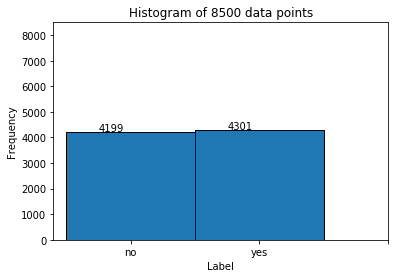

In [7]:
plot_histogram_from_labels(df3train.label.values, ["no", "yes"], "test.png") 

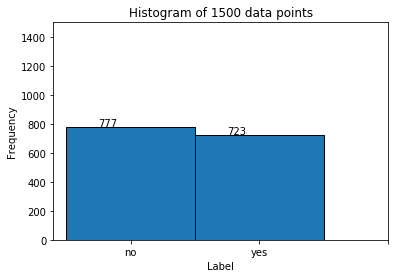

In [8]:
plot_histogram_from_labels(df3valid.label.values, ["no", "yes"], "test.png")

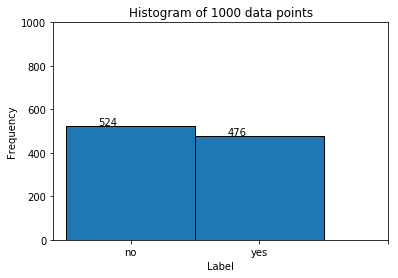

In [9]:
plot_histogram_from_labels(df3test.label.values, ["no", "yes"], "test.png") 

In [10]:
simple_pre_process_text_df(df3, "sentence1")
simple_pre_process_text_df(df3, "sentence2")
simple_pre_process_text_df(df3, "and_A")
simple_pre_process_text_df(df3, "and_B")

df3["text"] = df3["sentence1"] + ", " + df3["sentence2"]

# creating vocab and tensor data

In [11]:
df3_little = df3[["text", "label"]]

In [12]:
df3_little.head()

,text,label
0,"june and ross have traveled to arad, ross didn...",1
1,"claudia has traveled to mangalia and slobozia,...",1
2,"byron has traveled to turda and bucharest, dwi...",0
3,"emily has visited deva and arad, emily didnt v...",1
4,"tyler and nancy have visited bucharest, tyler ...",1


In [13]:
train_data_path = "data/boolean_3_train_lab.csv"
df3_little.to_csv(train_data_path, header=False, index=False)

In [14]:
TEXT = data.Field()
LABEL = data.LabelField(tensor_type=torch.FloatTensor)
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

In [15]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [16]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 708
len(LABEL.vocab): 2


In [17]:
def finde_size(list_):
    return np.max(list(map(lambda x: len(x.split(" ")), list_)))

In [18]:
def str_list2tensor(list_):
    list_i = []
    max_size = finde_size(list_)
    for line in list_:
        line = line.split(" ")
        size = len(line) 
        tail = max_size - size
        line += [TEXT.pad_token] * tail
        new_line = [TEXT.vocab.stoi[word] for word in line]
        list_i.append(new_line)
    return torch.tensor(list_i, dtype=torch.long, device=device)
    

In [19]:
exampleS1_train_t = str_list2tensor(list(df3train.sentence1.values))
exampleS2_train_t = str_list2tensor(list(df3train.sentence2.values))
exampleA_train_t = str_list2tensor(list(df3train.and_A.values))
exampleB_train_t = str_list2tensor(list(df3train.and_B.values))
exampleLabel_train = torch.tensor(list(df3train.label.values), dtype=torch.long, device=device)

In [20]:
exampleS1_valid_t = str_list2tensor(list(df3valid.sentence1.values))
exampleS2_valid_t = str_list2tensor(list(df3valid.sentence2.values))
exampleA_valid_t = str_list2tensor(list(df3valid.and_A.values))
exampleB_valid_t = str_list2tensor(list(df3valid.and_B.values))
exampleLabel_valid = torch.tensor(list(df3valid.label.values), dtype=torch.long, device=device)

In [21]:
exampleS1_test_t = str_list2tensor(list(df3test.sentence1.values))
exampleS2_test_t = str_list2tensor(list(df3test.sentence2.values))
exampleA_test_t = str_list2tensor(list(df3test.and_A.values))
exampleB_test_t = str_list2tensor(list(df3test.and_B.values))
exampleLabel_test = torch.tensor(list(df3test.label.values), dtype=torch.long, device=device)

In [22]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(exampleS1_train_t, exampleS2_train_t, exampleA_train_t, exampleB_train_t, exampleLabel_train)
valid_dataset = TensorDataset(exampleS1_valid_t, exampleS2_valid_t, exampleA_valid_t, exampleB_valid_t, exampleLabel_valid)
test_dataset = TensorDataset(exampleS1_test_t, exampleS2_test_t, exampleA_test_t, exampleB_test_t, exampleLabel_test)

In [23]:
from torch.utils.data import DataLoader

class DataHolder():
    """
    Class to store all data using the GentleLoader.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_loader = DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset,
                                        batch_size=test_batch,
                                        shuffle=True)

In [24]:
config = RNNConfig()
b_data = DataHolder(config,
                    train_dataset,
                    valid_dataset,
                    test_dataset)

# defining the model

In [25]:
class AddRNN(nn.Module):
    def __init__(self, config):
        super(AddRNN, self).__init__()
        self.vocab_size = config.vocab_size
        self.embedding_dim = config.embedding_dim
        self.output_dim = config.output_dim
        self.rnn_dim = config.rnn_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.rnn = nn.GRU(self.embedding_dim, self.rnn_dim) 
        self.fcA = nn.Linear(self.rnn_dim, self.rnn_dim)
        self.fcB = nn.Linear(self.rnn_dim, self.rnn_dim)
        self.fc_out = nn.Linear(self.rnn_dim, self.output_dim)
        self.fc_inf = nn.Linear(self.rnn_dim * 2, self.rnn_dim)
        
        
    def encode(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros((1, x.shape[1], self.rnn_dim), device=device)
        embedded = self.embedding(x)       
        output, hidden = self.rnn(embedded, hidden)
        hidden = hidden.squeeze(0)
        return hidden

    def forward(self, s1, s2):
        h = self.encode(s1)
        self.ha = self.fcA(h)
        self.hb = self.fcB(h)
#         h_inf = self.ha + self.hb
#         h_inf = self.ha * self.hb
        h_inf = self.fc_inf(torch.cat([self.ha, self.hb], dim=1))
        h_inf = h_inf.view((1, h_inf.shape[0], h_inf.shape[1]))
        s2_enc = self.encode(s2, h_inf)
        out = self.fc_out(s2_enc)
        return out

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_labels(self,s1, s2, labels):
        prediction = self.predict(s1, s2)
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct / labels.shape[0])
        prediction = prediction.numpy()
        labels = labels.numpy()
        return accuracy, prediction, labels

In [26]:
s1, s2, and_A, and_B, label = next(iter(b_data.train_loader))
s1 = s1.view((s1.shape[1], s1.shape[0]))
s2 = s2.view((s2.shape[1], s2.shape[0]))
and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
and_B = and_B.view((and_B.shape[1], and_B.shape[0]))

In [27]:
config = RNNConfig(vocab_size=len(TEXT.vocab), rnn_dim = 10, learning_rate = 0.12)
print(config)

vocab_size = 708
batch_size = 32
embedding_dim = 100
rnn_dim = 10
output_dim = 2
epochs = 8
learning_rate = 0.12
momentum = 0.2



In [28]:
model = AddRNN(config)

out = model.predict(s1, s2)
print(out)

tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 1])


mean valid acc before training =  0.5125


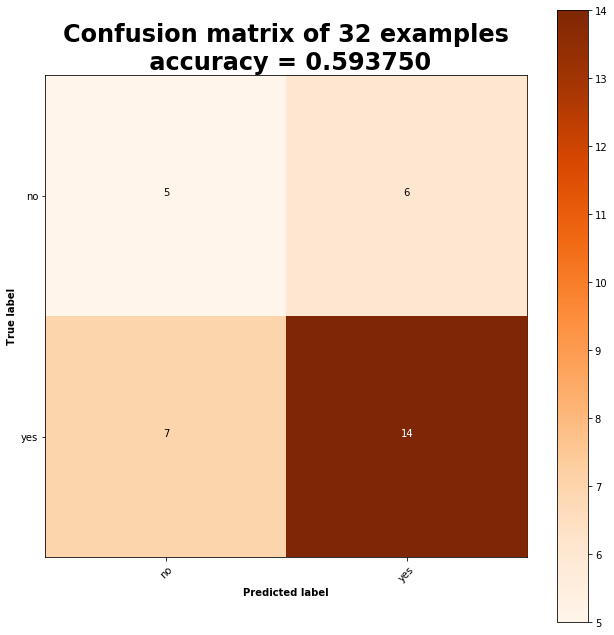

In [29]:
all_acc = 0
n_iter = 10
for i in range(n_iter):
    s1, s2, and_A, and_B, labels = next(iter(b_data.valid_loader))
    s1 = s1.view((s1.shape[1], s1.shape[0]))
    s2 = s2.view((s2.shape[1], s2.shape[0]))
    and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
    and_B = and_B.view((and_B.shape[1], and_B.shape[0]))

    acc, prediction, labels = model.evaluate_labels(s1, s2, labels)
    all_acc += acc

print("mean valid acc before training =  {}".format(all_acc / n_iter))    
plot_confusion_matrix(labels,
                      prediction,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

# defining the training loop

In [30]:
def train_in_epoch(model,
                   loader,
                   optimizer,
                   criterionCE,
                   criterionL1):
    """
    Train the model using all the data from the iterator

    Negative is a flag to train the model to maximize the
    loss functionCE

    :param model: RNN classification model
    :type model: RNN
    :param loader: data loader
    :type loader: torch.utils.data.dataloader.DataLoader
    :param optimizer: torch optimizer
    :type optimizer: optim.SGD, etc.
    :param criterionCE: loss criterion
    :type criterionCE: nn.CrossEntropyLoss
    :param criterionL1: loss criterion
    :type criterionL1: nn.L1Loss
    :return: mean loss, mean accuracy
    :rtype: float, float
    """

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in loader:
        optimizer.zero_grad()
        s1, s2, and_A, and_B, labels = batch
        s1 = s1.view((s1.shape[1], s1.shape[0]))
        s2 = s2.view((s2.shape[1], s2.shape[0]))
        and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
        and_B = and_B.view((and_B.shape[1], and_B.shape[0]))
        logits = model(s1, s2)
        ha = model.encode(and_A)
        hb = model.encode(and_B)
        loss = criterionCE(logits,labels) + torch.sqrt(criterionL1(ha, model.ha) + criterionL1(hb, model.hb))
#         loss = criterionCE(logits,labels)**2 + torch.sqrt(criterionL1(ha, model.ha) + criterionL1(hb, model.hb))

#         loss = criterionCE(logits,labels)  
#         loss = criterionCE(logits,labels) + criterionL1(ha, model.ha) + criterionL1(hb, model.hb)

        loss.backward()
        optimizer.step()
        acc, _, _ = model.evaluate_labels(s1, s2, labels)
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(loader)
    mean_acc = epoch_acc / len(loader)

    return mean_loss, mean_acc

### testing

In [31]:
dataholder = b_data

train_loader = dataholder.train_loader
valid_loader = dataholder.valid_loader

criterionCE = nn.CrossEntropyLoss()
criterionL1 = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config.learning_rate,
                            momentum=config.momentum)

mean_loss, mean_acc = train_in_epoch(model,
                                     train_loader,
                                     optimizer,
                                     criterionCE,
                                     criterionL1)

print(mean_loss, mean_acc)

9.823860896261115 0.5494125940297779


In [32]:
def get_valid_loss(model,
                   valid_loader,
                   criterionCE,
                   criterionL1):
    """
    Get the valid loss

    :param model: RNN classification model
    :type model:
    :param valid_iter: valid iterator
    :type valid_iter: data.BucketIterator
    :param criterion: loss criterion
    :type criterion: nn.CrossEntropyLoss
    :return: valid loss
    :rtype: Tensor(shape=[])
    """
    batch = next(iter(valid_loader))
    s1, s2, and_A, and_B, labels = batch
    s1 = s1.view((s1.shape[1], s1.shape[0]))
    s2 = s2.view((s2.shape[1], s2.shape[0]))
    and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
    and_B = and_B.view((and_B.shape[1], and_B.shape[0]))
    model.eval()
    logits = model(s1, s2)
    ha = model.encode(and_A)
    hb = model.encode(and_B)
#     loss = criterionCE(logits,labels)**2 + torch.sqrt(criterionL1(ha, model.ha) + criterionL1(hb, model.hb))
    
    loss = criterionCE(logits,labels) + torch.sqrt(criterionL1(ha, model.ha) + criterionL1(hb, model.hb))
#     loss = criterionCE(logits,labels) + criterionL1(ha, model.ha) + criterionL1(hb, model.hb)
    
#     loss = criterionCE(logits,labels)
    return loss.item()

### testing

In [33]:
get_valid_loss(model,
               valid_loader,
               criterionCE,
               criterionL1)

13.409843444824219

In [34]:
def training_loop_text_classification(model,
                                      config,
                                      dataholder,
                                      model_path,
                                      verbose=True,
                                      plot_path="training plot.png"):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: RNN
    :param config: classification model config
    :type config: RNNConfig
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    criterionCE = nn.CrossEntropyLoss()
    criterionL1 = nn.L1Loss()
#     criterionL1 = nn.MSELoss()
    
    optimizer = torch.optim.SGD(model.parameters(),
                            lr=config.learning_rate,
                            momentum=config.momentum)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterionCE = criterionCE.to(device)
    criterionL1 = criterionL1.to(device)
    
    train_loader = dataholder.train_loader
    valid_loader = dataholder.valid_loader

    best_valid_loss = float("inf")

    all_train_loss = []
    all_valid_loss = []

    for epoch in range(config.epochs):

        if verbose:
            print("epoch = ({}/{})".format(epoch + 1, config.epochs))
            train_loss, train_acc = train_in_epoch(model,
                                                   train_loader,
                                                   optimizer,
                                                   criterionCE,
                                                   criterionL1)

        all_train_loss.append(train_loss)
        valid_loss = get_valid_loss(model,
                                    valid_loader,
                                    criterionCE,
                                    criterionL1)
        all_valid_loss.append(valid_loss)

        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),  # noqa
                                                                   float(valid_loss))  # noqa

        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)

        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))

    if verbose:
        x = np.arange(1, len(all_train_loss) + 1, 1)
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(x, all_train_loss, label='mean train loss')
        ax.plot(x, all_valid_loss, label='mean valid loss')
        ax.legend()
        plt.xlabel('epoch')
        plt.ylabel('mean loss')
        plt.title('Train and valid mean loss')
        plt.grid(True)
        plt.savefig(plot_path)

### runnig one training

epoch = (1/30)

train_loss = 10.589 | valid_loss = 7.924
train_acc = 0.5049107141960832

epoch = (2/30)

train_loss = 7.179 | valid_loss = 7.413
train_acc = 0.5180451128267705

epoch = (3/30)

train_loss = 6.656 | valid_loss = 7.865
train_acc = 0.512124060240007

epoch = (4/30)

train_loss = 6.583 | valid_loss = 8.028
train_acc = 0.4980263157670659

epoch = (5/30)

train_loss = 6.406 | valid_loss = 6.865
train_acc = 0.509351503804214

epoch = (6/30)

train_loss = 6.316 | valid_loss = 7.662
train_acc = 0.5153900375939849

epoch = (7/30)

train_loss = 6.299 | valid_loss = 8.188
train_acc = 0.5177396616541353

epoch = (8/30)

train_loss = 6.270 | valid_loss = 6.976
train_acc = 0.5163298872180451

epoch = (9/30)

train_loss = 6.122 | valid_loss = 5.148
train_acc = 0.5191729324204581

epoch = (10/30)

train_loss = 5.639 | valid_loss = 6.933
train_acc = 0.5205827068565483

epoch = (11/30)

train_loss = 5.331 | valid_loss = 6.284
train_acc = 0.5164473684210527

epoch = (12/30)

train_loss = 5

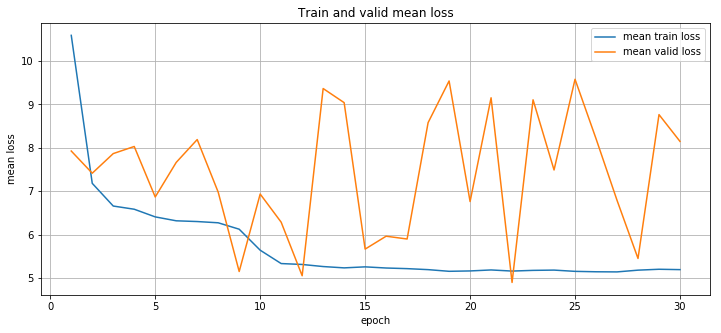

In [35]:
config = RNNConfig(vocab_size=len(TEXT.vocab), rnn_dim = 10, learning_rate = 0.02)
model = AddRNN(config)

config.epochs = 30 
training_loop_text_classification(model=model,
                                  config=config,
                                  dataholder=b_data,
                                  model_path="temp.pkl")

### Evaluating the model after the training

mean valid acc after training =  0.478125


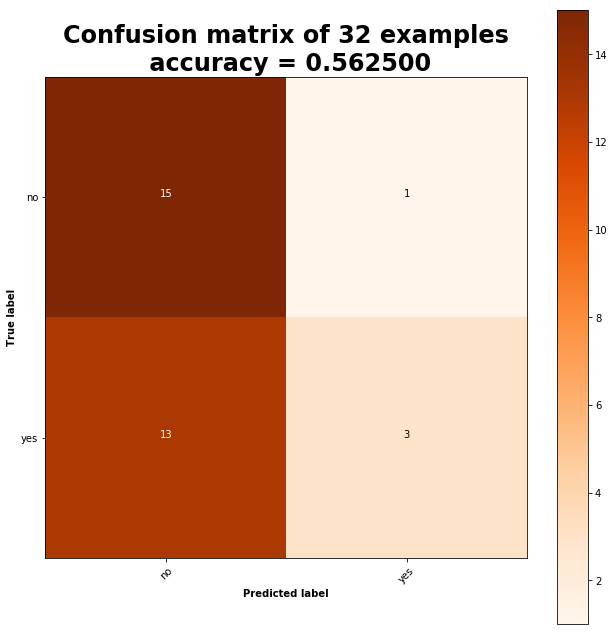

In [36]:
model = AddRNN(config)
model.load_state_dict(torch.load("temp.pkl"))

all_acc = 0
n_iter = 10
for i in range(n_iter):
    s1, s2, and_A, and_B, labels = next(iter(b_data.valid_loader))
    s1 = s1.view((s1.shape[1], s1.shape[0]))
    s2 = s2.view((s2.shape[1], s2.shape[0]))
    and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
    and_B = and_B.view((and_B.shape[1], and_B.shape[0]))

    acc, prediction, labels = model.evaluate_labels(s1, s2, labels)
    all_acc += acc

print("mean valid acc after training =  {}".format(all_acc / n_iter))    
plot_confusion_matrix(labels,
                      prediction,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

In [37]:
model = AddRNN(config)
model.load_state_dict(torch.load("temp.pkl"))
s1, s2, and_A, and_B, labels = next(iter(b_data.valid_loader))
s1 = s1.view((s1.shape[1], s1.shape[0]))
s2 = s2.view((s2.shape[1], s2.shape[0]))
and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
and_B = and_B.view((and_B.shape[1], and_B.shape[0]))
_ = model(s1, s2)
hahat = model.ha.detach().numpy()
hbhat = model.hb.detach().numpy()
ha = model.encode(and_A).detach().numpy()
hb = model.encode(and_B).detach().numpy()

In [38]:
comp_a = np.mean((hahat - ha)**2, axis=1)
comp_b = np.mean((hbhat - hb)**2, axis=1)

In [39]:
print(comp_a, ">>>>>>>>>>>>>>>>>" ,np.mean(comp_a), np.std(comp_a))

[0.00064972 0.00110769 0.00072964 0.00069306 0.00068561 0.00069541
 0.00042231 0.00041803 0.00061913 0.00081884 0.00060503 0.00070098
 0.00072252 0.00071188 0.001956   0.00014333 0.00071563 0.0006713
 0.00272262 0.00050442 0.00055946 0.00069548 0.00082022 0.00091842
 0.00069296 0.00046889 0.00061026 0.0006619  0.00122368 0.00201718
 0.00067195 0.00063855] >>>>>>>>>>>>>>>>> 0.0008210028 0.00050201744


In [40]:
print(comp_b, ">>>>>>>>>>>>>>>>>" ,np.mean(comp_b), np.std(comp_b))

[0.00228425 0.00072767 0.00069087 0.00182411 0.00206964 0.00212981
 0.00057577 0.0014146  0.00157666 0.00051166 0.00233375 0.00207437
 0.00200976 0.00227717 0.00133033 0.00046487 0.00209734 0.00214477
 0.00227579 0.00034679 0.00187404 0.00211337 0.00193242 0.00102825
 0.00093381 0.00148911 0.00221219 0.00204212 0.00064989 0.00150598
 0.00206368 0.0019708 ] >>>>>>>>>>>>>>>>> 0.0015929886 0.00064379175
